In this notebook I show how to compare different repertoires through the models' scores to obtain specificity scores and the AUROCs of comparison (Fig. 4,S5,S6)

In [1]:
rootf = '/home/barbara/Barbara_Bravi/rbm_tcell' ## place here the folder where you save all the folders of the git ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Garuda']
mpl.rcParams['font.serif'] = ['Garuda-Oblique']
import csv
curr_float = np.float32
curr_int = np.int16

def convert_number(seqs): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadict = {aa[k]: k for k in range(len(aa))}
    msa_num = np.array(list(map(lambda x: [aadict[y] for y in x], seqs[0:])), dtype=curr_int, order="c")
    
    return msa_num

def convert_letter(seqs_n): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadictinv = {k: aa[k] for k in range(len(aa))} 
    seqs=[]
    if type(seqs_n[0]) == curr_int:
        seqs.append(''.join([aadictinv[e] for e in seqs_n]))
    else:
        for t in range(len(seqs_n)):
            seqs.append(''.join([aadictinv[e] for e in seqs_n[t]]))
    return seqs

def uniqueIndexes(l):
    seen = set()
    res = []
    for i, n in enumerate(l):
        if n not in seen:
            res.append(i)
            seen.add(n)
    return res

#%matplotlib inline
import sys, os, pickle
sys.path.append('/home/barbara/.local/lib/python3.6/site-packages/')
sys.path.append(rootf + '/PGM/source/')
sys.path.append(rootf + '/PGM/utilities/')
sys.path.append(rootf + '/Align_utils/')
from common_imports import set_num_threads
set_num_threads(1) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm,utilities
import Proteins_utils, RBM_utils, utilities, sequence_logo, plots_utils

/home/barbara/Barbara_Bravi/rbm_tcell/PGM/source/numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/barbara/Barbara_Bravi/rbm_tcell/PGM/source/numba_utilities.py:1125: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
/home/barbara/Barbara_Bravi/rbm_tcell/PGM/source/numba_utilities.py:1126: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
/home/barbara/Barbara_Bravi/rbm_tcell/PGM/source/numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: F

The first step is the estimation of each sequence's abundance and likelihood under each condition (model)

In [2]:
remback=0 ## this variable tells whether the background probability should be substracted

def ll_seq_pp(data_seqs_val_3w_n,ptnm,pepm,Nm_w,hu,l12,remback):
    nm = rootf + '/Models/CDR3out_pt' + str(int(ptnm)) + '_' + pepm + '_' + str(int(Nm_w)) + 'w/model_' + str(hu) + '_' + str(l12) + '.data'
    RBM = RBM_utils.loadRBM(nm)
    
    if remback==1:
        nmd0 = rootf + '/Models/CDR3out_pt' + str(int(ptnm)) + '_day0/model_' + str(hu) + '_' + str(l12) + '.data'
        RBM_d0 = RBM_utils.loadRBM(nmd0)
        ll =  RBM.likelihood(data_seqs_val_3w_n) - RBM_d0.likelihood(data_seqs_val_3w_n)
    else:
        ll = RBM.likelihood(data_seqs_val_3w_n)
		
    return ll

path_in = rootf + '/Data/CDR3'
n_v = 19 # Number of visible units; = # sites in alignment.
n_h = 25 # Number of hidden units.
hu = n_h

l12 = 0.1
TS = 80
import pandas as pd

def countX(lst, x): 
    return lst.count(x) 

listpep1 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep2 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep3 = ['NA', 'CR'];
listpep4 = ['WT', 'NA', 'CR'];
listpep5 = ['NA', 'CR'];
listpep6 = ['NA1', 'NA2', 'CR1', 'CR2'];
listpep7 = ['NA','CR']; 
listpep=[listpep1,listpep2,listpep3,listpep4,listpep5,listpep6,listpep7];

# Lists of LL under different models for validation sequences

list_3w = [1,2,3,4,5,6,7]

N=19
q=21
N_model=N
hu = 25
l12 = 0.1

for pp in list_3w:
    
    ptn=pp
    nd = rootf + '/Data/Count-weighted/Validation/CDR3fasta_pt' + str(int(ptn)) + '_full_3w_02.fasta'
    data_val_3w_n = Proteins_utils.load_FASTA(nd, with_labels=False, remove_insertions=False, drop_duplicates=False)
    data_val_3w = convert_letter(data_val_3w_n)
    
    listll=[]
    listfc=[]
    for r in range(len(listpep[pp-1])):
        pep=listpep[pp-1][r]
        ll = ll_seq_pp(data_val_3w_n,ptn,pep,3,hu, l12,remback)
        
        summary = pd.read_csv(rootf + '/Data/summary_pt'+str(ptn)+'_'+ pep + '.tsv', sep='\t', low_memory=False)
        mult3w = (summary['Mult 3w (rep)'].values)
        multd0 = (summary['Mult day0 (rep)'].values)
        
        fc = np.zeros(len(data_val_3w_n)) 
        ps = 0.5
        seqs_g = list(summary['CDR3_gap'].values.astype(np.str))
        for s0 in range(len(data_val_3w)):
            s=data_val_3w[s0]
            if s in seqs_g:
                ind = seqs_g.index(s)
                if remback==0:
                    fc[s0] = np.log10((mult3w[ind]+ps))
                else:
                    fc[s0] = np.log10((mult3w[ind]+ps)/(multd0[ind]+ps))
                    
        listll.append(ll)
        listfc.append(fc)
    
    ztot=zip(data_val_3w,*listll)
    
    nr=rootf + '/Data/Specificity_tables/RBM/rank_LL_pt' + str(int(ptn)) + '_auroc.txt'    
    with open(nr, 'w') as out_f:
        title= 'CDR3' + '\t'
        for r in range(len(listpep[pp-1])):
            pep=listpep[pp-1][r]
            title = title + pep + '\t'
        out_f.write(title + '\n')
        writer = csv.writer(out_f, delimiter='\t')
        writer.writerows(ztot)  
        
    ztot=zip(data_val_3w,*listfc)
    
    nr=rootf + '/Data/Specificity_tables/rank_LL_pt' + str(int(ptn)) + '_log10fc.txt'    
    with open(nr, 'w') as out_f:
        title= 'CDR3' + '\t'
        for r in range(len(listpep[pp-1])):
            pep=listpep[pp-1][r]
            title = title + pep + '\t'
        out_f.write(title + '\n')
        writer = csv.writer(out_f, delimiter='\t')
        writer.writerows(ztot) 

Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (500, 25), [10, 25], reinitializating I
Mismatch dimensions (500, 19, 21), [10, 19, 

Scores are next put together to obtain the AUROC of specificity

In [3]:
from sklearn import metrics
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import patches
from pandas.plotting import table

mpl.rcParams['font.family'] = ['Garuda']
mpl.rcParams['font.serif'] = ['Garuda-Oblique']

beginl=1 
list_pat=[]
list_pep=[]
list_auc=[] 

fold_model = 'RBM' ## as alternative, there are the tables with scores from RBM_LR, SONIA, PWM
#fold_model = 'RBM_LR'
#fold_model = 'SONIA'
#fold_model = 'PWM'

for pp in range(1,8):
    
    print('Patient')
    print(pp)
    
    ptn=pp
    for r in range(len(listpep[pp-1])):
        
        pep=listpep[pp-1][r]  
        
        print(pep)
        seq1=[]
        i=1
        with open(rootf + '/Data/Count-weighted/Validation/CDR3fasta_pt' + str(pp) + '_' + pep + '_3w_02.fasta') as f:
            for line in f:
                if i % 2 == 0:
                    linesplit = line.strip().split('\t')
                    seq1.append(linesplit[0].replace('-',''))
                i=i+1
                
        ## Read the fold change and use it as label for 'specific expansion' ##
        seq2fc=[]
        seqfc=[]
        NF = rootf + '/Data/Specificity_tables/rank_LL_pt' + str(int(ptn)) + '_log10fc.txt'
        if fold_model == 'SONIA': ## For Sonia, we need the list of only sequences at P_gen non-zero
            NF = rootf + '/Data/Specificity_tables/' + fold_model + '/rank_LL_pt' + str(int(ptn)) + '_log10FC.txt'
        with open(NF) as f: 
            for line in f:
                linesplit = line.strip().split('\t')
                nogap2=linesplit[0].replace(' ','')
                seq2fc.append(nogap2)
                seqfc.append(linesplit[beginl:len(linesplit)])    
                
        PL=np.zeros(len(seq2fc)-1)
        for l in range(1,len(seq2fc)):
            listot=[]
            listdiff=[]
            for i in range(r):
                listot.append(float(seqfc[l][i]))
                listdiff.append(abs(float(seqfc[l][r])-float(seqfc[l][i])))
            for i in range(r+1,len(seqfc[l])):
                listot.append(float(seqfc[l][i]))
                listdiff.append(abs(float(seqfc[l][r])-float(seqfc[l][i])))
            score = float(seqfc[l][r]) - listot[np.argmin(listdiff)] # score as max among other log-likelihoods
            if np.argmax(seqfc[l]) == r:
                PL[l-1]=1
        labels=np.copy(PL)
        
        ## Here I read the scores assigned by a given model ##
        
        seq2=[]
        seqll=[]
        with open(rootf + '/Data/Specificity_tables/' + fold_model + '/rank_LL_pt' + str(int(ptn)) + '_auroc.txt') as f: 
            for line in f:
                linesplit = line.strip().split('\t')
                nogap2=linesplit[0].replace(' ','')
                seq2.append(nogap2)
                seqll.append(linesplit[beginl:len(linesplit)])
                
        PLL=np.zeros(len(seq2)-1)
        for l in range(1,len(seq2)):
            listot=[]
            listdiff=[]
            for i in range(r):
                listot.append(float(seqll[l][i]))
                listdiff.append(abs(float(seqll[l][r])-float(seqll[l][i])))
            for i in range(r+1,len(seqll[l])):
                listot.append(float(seqll[l][i]))
                listdiff.append(abs(float(seqll[l][r])-float(seqll[l][i])))
            score = float(seqll[l][r]) - listot[np.argmin(listdiff)]
            PLL[l-1] = score

        scores = np.copy(PLL) 
                
        fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
        auroc = metrics.auc(fpr, tpr)
        print(auroc)
        
        list_pat.append(pp)
        list_pep.append(pep)
        list_auc.append(auroc)      

Patient
1
WT
0.8489324969323362
NA
0.7011184435886595
MUC16ID
0.8359948356740465
MUC16WT
0.8446752274514575
CR
0.7346213220875984
Patient
2
WT
0.8950598979554693
NA
0.9224889893182538
MUC16ID
0.9354248060485743
MUC16WT
0.8526198737813533
CR
0.8734998898167663
Patient
3
NA
0.9125227338544206
CR
0.9125227338544206
Patient
4
WT
0.8217756490799026
NA
0.8775014506956786
CR
0.8113619271692881
Patient
5
NA
0.893689552871645
CR
0.8936895528716448
Patient
6
NA1
0.8686595577018386
NA2
0.8443551145147365
CR1
0.8639869436823345
CR2
0.9116920002166781
Patient
7
NA
0.6955879581218765
CR
0.6955879581218765


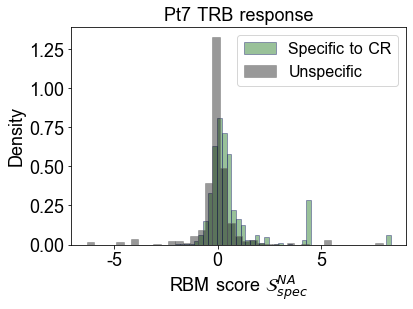

In [4]:
'''to add the reading of final files when paper is finalized instead of re-calculating'''

scores_p = [scores[p] for p in range(len(scores)) if labels[p]==1]/np.log(10)
scores_n = [scores[p] for p in range(len(scores)) if labels[p]==0]/np.log(10)

import seaborn as sns
fig,ax=plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(4)

w=5
colors = ['DarkGreen', 'black']
sns.distplot(scores_p, norm_hist = True,  hist_kws={'edgecolor':'MidnightBlue'}, color = colors[0], hist = True,kde=False, bins=int(230/5), rug=False, label = 'Specific to '+ pep, ax = ax)
sns.distplot(scores_n, norm_hist = True, hist_kws={'edgecolor':'DimGray'}, hist = True, bins=int(200/5), kde=False, color = colors[1], label = 'Unspecific', ax = ax)

s2=18
ax.set_xlabel(r'RBM score $\mathcal{S}^{NA}_{spec}$', fontsize = s2)
ax.set_ylabel('Density', fontsize = s2)
plt.legend( fontsize = s2-2)
ax.set_title('Pt' + str(pp) + ' TRB response', fontsize = s2)
ax.tick_params(axis='both', which='major', labelsize = s2)

Text(0, 0.5, 'Fraction of specific responders')

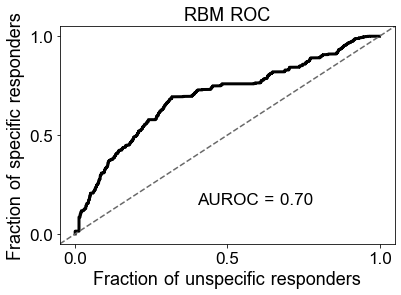

In [5]:
fig,ax2=plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(4)
s0=s2
ax2.plot(fpr,tpr,lw=3,color='k')
ax2.set_title(fold_model + ' ROC', fontsize=s0)
ax2.set_xticks([0,0.5,1])
ax2.set_yticks([0,0.5,1])
ax2.tick_params(axis='both', which='major', labelsize=s0-1)
ax2.text(0.4, 0.15, 'AUROC = ' + format(metrics.auc(fpr, tpr), '.2f'), fontsize=s0-1);
ax2.plot([0, 1], [0, 1], transform=ax2.transAxes, color='DimGray', linestyle='--');
ax2.set_xlabel('Fraction of unspecific responders', fontsize=s0)
ax2.set_ylabel('Fraction of specific responders', fontsize=s0)

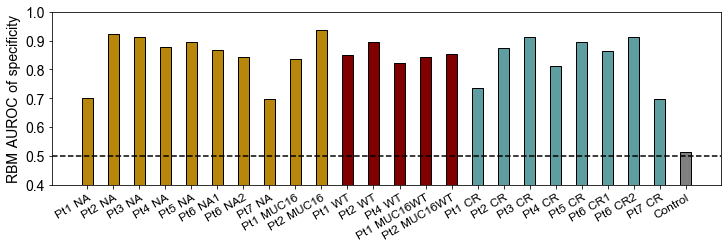

In [6]:
## Summary over all samples ##

name_tech = 'RBM AUROC of specificity'
import pandas as pd 

datao = {'Patient': list_pat,
        'Peptide': list_pep,
        name_tech: list_auc,
        }

df = pd.DataFrame (datao, columns = ['Patient','Peptide', name_tech])

list_NA = ['NA', 'NA1', 'NA2']
list_MUC16 = ['MUC16ID']
list_XRM = ['CR', 'CR1', 'CR2']
list_WT = ['WT']
list_MUC16WT = ['MUC16WT']

auroc_xrm = list(df[df['Peptide'].isin(list_XRM)][name_tech].values)
auroc_wt_muc = list(df[df['Peptide'].isin(list_WT)][name_tech].values) + list(df[df['Peptide'].isin(list_MUC16WT)][name_tech].values)
auroc_na_muc = list(df[df['Peptide'].isin(list_NA)][name_tech].values) + list(df[df['Peptide'].isin(list_MUC16)][name_tech].values)

names_na_muc=['Pt1 NA','Pt2 NA','Pt3 NA','Pt4 NA','Pt5 NA','Pt6 NA1', 'Pt6 NA2', 'Pt7 NA', 'Pt1 MUC16','Pt2 MUC16']
names_na = names_na_muc[:-2]
names_wt_muc=['Pt1 WT','Pt2 WT','Pt4 WT', 'Pt1 MUC16WT','Pt2 MUC16WT']
names_wt=names_wt_muc[:-2]
names_xrm=['Pt1 CR','Pt2 CR','Pt3 CR','Pt4 CR','Pt5 CR','Pt6 CR1', 'Pt6 CR2', 'Pt7 CR']

colors3 = list(np.repeat(['DarkGoldenRod'],len(names_na_muc))) + list(np.repeat(['Maroon'],len(names_wt_muc))) + list(np.repeat(['CadetBlue'],len(names_xrm)))
colors3.append('Gray')
s2=16
sc=2
fig,ax=plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(12)
fig.subplots_adjust(bottom = 0.4)

meth = names_na_muc + names_wt_muc + names_xrm + ['Control']
meth_val = np.array(auroc_na_muc + auroc_wt_muc + auroc_xrm + [0.514])

x_pos = np.arange(len(meth_val))
x_pos = np.arange(0,2*len(meth_val),2)
ax.bar(x_pos, meth_val, alpha=1, edgecolor='k', align = 'center', capsize=sc, color = colors3)
ax.set_ylim(0.4, 1)
ax.set_xticks(x_pos)
ax.set_ylabel(name_tech, fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize = 14)
ax.set_xticklabels(meth, rotation = 30, fontsize = 12, ha='right', rotation_mode = 'anchor')
plt.axhline(y=0.5, color='k', linestyle='--')

Here I add the same estimation of specificity for the Left-Right version version of RBM

In [7]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aadict = {amino_acids[k]: k for k in range(len(amino_acids))} 

max_L = 19
max_depth = max_L

features = []
for aa in amino_acids:
    features += [['a' + aa + str(L)] for L in range(max_depth)]
    features += [['a' + aa + str(L)] for L in range(-max_depth, 0)] # features for encoding

features_r = []
for aa in amino_acids:
    features_r += [['a\t' + aa + '\t' + str(L)] for L in range(max_depth)]
    features_r += [['a\t' + aa + '\t' + str(L)] for L in range(-max_depth, 0)]  # features for writing

feature_dict = {tuple(f): i for i, f in enumerate(features)}
feature_dict_inv = {i:f for i, f in enumerate(features)}


remback=0 ## this variable tells whether the background probability should be substracted

def ll_seq_pp_LR(data_seqs_val_3w_n,ptnm,pepm,Nm_w,hu,l12,remback):
     
    nm = rootf + '/Models/CDR3out_pt' + str(int(ptnm)) + '_' + pepm + '_' + str(int(Nm_w)) + 'w/model_' + str(hu) + '_' + str(l12) + '_LR.data'
    RBM = RBM_utils.loadRBM(nm)
    
    if remback==1:
        nmd0 = rootf + '/Models/CDR3out_pt' + str(int(ptnm)) + '_day0/model_' + str(hu) + '_' + str(l12) + '_LR.data'
        RBM_d0 = RBM_utils.loadRBM(nmd0)
        ll =  RBM.likelihood(data_seqs_val_3w_n.astype(np.int16)) - RBM_d0.likelihood(data_seqs_val_3w_n.astype(np.int16))
    else:
        ll = RBM.likelihood(data_seqs_val_3w_n.astype(np.int16))
		
    return ll

path_in = rootf + '/Data/CDR3'
n_v = 19 # Number of visible units; = # sites in alignment.
n_h = 25 # Number of hidden units.
hu = n_h

l12 = 0.1
TS = 80
import pandas as pd

def countX(lst, x): 
    return lst.count(x) 

listpep1 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep2 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep3 = ['NA', 'CR'];
listpep4 = ['WT', 'NA', 'CR'];
listpep5 = ['NA', 'CR'];
listpep6 = ['NA1', 'NA2', 'CR1', 'CR2'];
listpep7 = ['NA','CR']; 
listpep=[listpep1,listpep2,listpep3,listpep4,listpep5,listpep6,listpep7];

# Lists of LL under different models for validation sequences

list_3w = [1,2,3,4,5,6,7]

N=19
q=21
N_model=N
hu = 25
l12 = 0.1

for pp in list_3w:
    
    ptn=pp
    nd = rootf + '/Data/Count-weighted/Validation/CDR3fasta_pt' + str(int(ptn)) + '_full_3w_02.fasta'
    data_val_3w_n = Proteins_utils.load_FASTA(nd, with_labels=False, remove_insertions=False, drop_duplicates=False)
    data_val_3w = convert_letter(data_val_3w_n)
    
    data_seqs_val_3w = []
    for t in range(len(data_val_3w)):
        seq = data_val_3w[t].replace('-','')
        seq_feature_lsts = [['a' + aa + str(i)] for i, aa in enumerate(seq)]
        seq_feature_lsts += [['a' + aa + str(-1-i)] for i, aa in enumerate(seq[::-1])]
        seq_features = list(set([feature_dict[tuple(f)] for f in seq_feature_lsts if tuple(f) in feature_dict]))
        length_input=len(features)
        data=np.array(seq_features)
        data_enc = np.zeros(length_input, dtype=np.int8)
        for i in range(len(data)): data_enc[data[i]] = 1
        data_seqs_val_3w.append(list(data_enc))  
        
    data_seqs_val_3w_n = np.array(data_seqs_val_3w).astype(np.int16)
    
    listll=[]
    listfc=[]
    for r in range(len(listpep[pp-1])):
        pep=listpep[pp-1][r]
        ll = ll_seq_pp_LR(data_seqs_val_3w_n,ptn,pep,3,hu, l12,remback)
                    
        listll.append(ll)
    
    ztot=zip(data_val_3w,*listll)
    
    nr=rootf + '/Data/Specificity_tables/RBM_LR/rank_LL_pt' + str(int(ptn)) + '_auroc.txt'    
    with open(nr, 'w') as out_f:
        title= 'CDR3' + '\t'
        for r in range(len(listpep[pp-1])):
            pep=listpep[pp-1][r]
            title = title + pep + '\t'
        out_f.write(title + '\n')
        writer = csv.writer(out_f, delimiter='\t')
        writer.writerows(ztot)  

Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760, 2], reinitializating I
Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760, 2], reinitializating I
Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760, 2], reinitializating I
Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760, 2], reinitializating I
Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760, 2], reinitializating I
Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760, 2], reinitializating I
Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760, 2], reinitializating I
Mismatch dimensions (200, 25), [10, 25], reinitializating I
Mismatch dimensions (200, 760, 2), [10, 760,